In [59]:
#import cleaned data
#need to clean the data
# one-hot encoding necessary for agency? unclear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_precision_recall_curve

In [3]:
data = pd.read_csv('hmda_2017_nationwide_all-records_codes.csv')

In [44]:
sample = data.sample(n=100000, random_state = 0)
sample = sample[(sample['action_taken'] == 1) | (sample['action_taken'] ==3) |
                (sample['action_taken'] ==4) | (sample['action_taken'] ==5)]

In [45]:
print(sample.shape)
sample.head()

(81346, 45)


,as_of_year,respondent_id,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,...,lien_status,edit_status,sequence_number,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,application_date_indicator
9956322,2017,0000614313,2,2,1,1,1,81.0,2,1,...,1,NaN,NaN,4037.0,7.65,57600.0,108.57,1335.0,1760.0,NaN
12374321,2017,3827009995,7,1,1,1,2,123.0,3,1,...,1,NaN,NaN,8180.0,8.44,72500.0,132.92,2826.0,4046.0,NaN
2339745,2017,0000146672,9,3,1,3,1,362.0,3,1,...,1,NaN,NaN,5704.0,10.59,61800.0,100.76,1545.0,2277.0,NaN
10137772,2017,0000024524,5,1,1,2,1,2.0,3,1,...,3,NaN,NaN,218.0,26.61,66600.0,63.17,65.0,121.0,NaN
13196228,2017,41-1795868,7,1,1,3,1,72.0,3,3,...,1,NaN,NaN,5019.0,11.66,53300.0,96.32,1622.0,2231.0,NaN


Cleaning data basic steps:
1) change label to binary 
    https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf
    Here, we're only saying 1 if it was approved, 0 if anything else in the data happened.
    
2) impute missing values

3) split sets

In [46]:
sample['label'] = np.where(sample['action_taken'] == 1, 1, 0)

features = sample.loc[:,['population','minority_population','hud_median_family_income','tract_to_msamd_income','number_of_1_to_4_family_units']]
label = sample['label']

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2, random_state=0)

In [47]:
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train = impute_features.fit_transform(x_train)

In [48]:
impute_features.statistics_

array([5.1340e+03, 2.4750e+01, 6.7900e+04, 1.0753e+02, 1.8120e+03])

In [49]:
parameters = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid.fit(x_train, y_train)

results = pd.DataFrame.from_dict(grid.cv_results_)
results[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.639529,0.993655,0.637955
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.639529,0.993655,0.637955
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.639529,0.993655,0.637955
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.638500,0.978825,0.639962
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.638500,0.978825,0.639962
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.638515,0.978849,0.639968
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632076,1.000000,0.632076


Only using Census indicators provides limited accuracy. Limiting the outcome variables also, unsurprisingly, increases accuracy (not predicting pre approval, loan purchases, or approved but not accepted).

Including loan purpose, applicant one race, and sex:

In [52]:
features2 = sample.loc[:,['loan_purpose','applicant_race_1','applicant_sex','population','minority_population','hud_median_family_income','tract_to_msamd_income','number_of_1_to_4_family_units']]
label2 = sample['label']

x_train2, x_test2, y_train2, y_test2 = train_test_split(features2, label2, test_size = .2, random_state=0)

In [56]:
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train2 = impute_features.fit_transform(x_train2)

In [57]:
parameters2 = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini'],'min_samples_split':[2,5,10]}

grid2 = GridSearchCV(DecisionTreeClassifier(), parameters2, scoring = ['accuracy', 'recall', 'precision'], cv=10, refit='accuracy')

grid2.fit(x_train2, y_train2)

results2 = pd.DataFrame.from_dict(grid2.cv_results_)
results2[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
1,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
2,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.632076,1.000000,0.632076
3,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.641896,0.913473,0.655945
4,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.641896,0.913473,0.655945
5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.641896,0.913473,0.655945
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.651438,0.899108,0.666252
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.651423,0.899084,0.666246
8,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.651392,0.899035,0.666233
9,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.632076,1.000000,0.632076


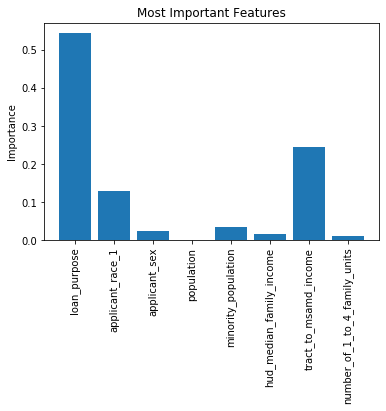

In [68]:
feature_scores = grid2.best_estimator_.feature_importances_
feature_labels = features2.columns.values
# Plot
plt.figure()
plt.bar(feature_labels, feature_scores)
plt.title('Most Important Features')
plt.ylabel('Importance')
plt.xticks(range(8), feature_labels, rotation=90)
plt.show()

In [66]:
grid2.best_estimator_.feature_importances_

array([0.54445407, 0.12849986, 0.02272003, 0.        , 0.03483381,
       0.01524342, 0.24400539, 0.01024343])

In [67]:
features.columns.values

array(['population', 'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_1_to_4_family_units'],
      dtype=object)